# Prerequisite

Following packages must be installed to run codes below

```bash
$ pip3 install openpyxl 
```


In [1]:
%load_ext autoreload
%autoreload 2

# Add project path

In [2]:
import os
import sys
from pathlib import Path

PROJECT_PATH = Path().resolve().parent.parent
SRC_PATH = PROJECT_PATH / 'src'

sys.path.append(str(SRC_PATH))

In [3]:
exp_name = 'baseline_beavers_model'

# Load data

In [4]:
from data_loader import SectorDataLoader

data_loader = SectorDataLoader()
data = (
    data_loader
    .load_dataset()
    .pipe(data_loader.add_beaver_indicator)
    .pipe(data_loader.add_label)
)

# Baseline classifier using Beaver's features

In [5]:
from project_paths import DATA_PATH

sectors = [
    '제조업(10~34)',
    '부동산업(68)',
    '도매 및 소매업(45~47)',
    '숙박 및 음식점업(55~56)',
    '건설업(41~42)'
]

beaver_features = [
    '유동자산/부채총계',
    '당기순이익(손실)/자산총계',
    '부채총계/자산총계',
    '순운전자본/자산총계',
    '유동부채/유동자산'
]

years_to_close = [
    'Closed_In_1Yr',
    'Closed_In_2Yrs',
]

x_data_year = list(range(2018, 2021))

EXP_RESULT_PATH = DATA_PATH / 'experiment_result' / exp_name

if not os.path.exists(EXP_RESULT_PATH) : 
    os.mkdir(EXP_RESULT_PATH)

In [6]:
import numpy as np
import pandas as pd
from pycaret.classification import ClassificationExperiment
from tqdm import tqdm

exp_result = None

for target_years_to_close in tqdm(years_to_close) : 
    for x_data_target_year in tqdm(x_data_year, leave=True) : 
        for sector in sectors : 

            filename = EXP_RESULT_PATH / f'Beaver_baseline_{sector}_{target_years_to_close}_{x_data_target_year}.csv'

            if not os.path.exists(filename) : 

                data_to_train = (
                    data
                    .loc[~data[beaver_features[0]].isin([np.nan, np.inf, -np.inf]), :]
                    .loc[~data[beaver_features[1]].isin([np.nan, np.inf, -np.inf]), :]
                    .loc[~data[beaver_features[2]].isin([np.nan, np.inf, -np.inf]), :]
                    .loc[~data[beaver_features[3]].isin([np.nan, np.inf, -np.inf]), :]
                    .loc[~data[beaver_features[4]].isin([np.nan, np.inf, -np.inf]), :]
                    .loc[lambda x : pd.to_datetime(x['결산년월'], format='%Y%m%d').dt.year==x_data_target_year]
                    .loc[lambda x : x['대분류']==sector]
                )
                print(filename)
                display(data_to_train)

                exp = ClassificationExperiment()

                exp.setup(
                    (
                        data_to_train
                        .loc[:, beaver_features+[target_years_to_close]]
                        .reset_index(drop=True)
                    ),
                    target=target_years_to_close
                )

                models = exp.compare_models()

                result = (
                    exp.pull()
                    .assign(target=target_years_to_close)
                    .assign(x_data_yaer=x_data_target_year)
                    .assign(대분류=sector)
                    .reset_index(drop=False)
                    .rename(columns={'index':'model_name'})
                )
                result.to_csv(filename)

            else : 
                result = pd.read_csv(filename)

            if exp_result is None : 
                exp_result = result
            else : 
                exp_result = pd.concat([exp_result, result], axis=0)

100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.40it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]


In [7]:
aggregated_result_path = EXP_RESULT_PATH / 'result.csv'

if not os.path.exists(aggregated_result_path) :
    exp_result.to_csv(aggregated_result_path)
    
exp_result

,Unnamed: 0,model_name,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),target,x_data_yaer,대분류
0,0,lr,Logistic Regression,0.8705,0.4832,0.0059,0.1000,0.0111,0.0098,0.0226,0.189,Closed_In_1Yr,2018,제조업(10~34)
1,1,ridge,Ridge Classifier,0.8705,0.0000,0.0059,0.1000,0.0111,0.0098,0.0226,0.005,Closed_In_1Yr,2018,제조업(10~34)
2,2,lda,Linear Discriminant Analysis,0.8697,0.4930,0.0059,0.1000,0.0111,0.0082,0.0192,0.006,Closed_In_1Yr,2018,제조업(10~34)
3,3,dummy,Dummy Classifier,0.8697,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.006,Closed_In_1Yr,2018,제조업(10~34)
4,4,rf,Random Forest Classifier,0.8674,0.5316,0.0860,0.4458,0.1413,0.1068,0.1524,0.079,Closed_In_1Yr,2018,제조업(10~34)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,5,ada,Ada Boost Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,NaN,0.0000,0.007,Closed_In_2Yrs,2020,건설업(41~42)
6,6,lda,Linear Discriminant Analysis,1.0000,0.0000,1.0000,1.0000,1.0000,NaN,0.0000,0.007,Closed_In_2Yrs,2020,건설업(41~42)
7,7,et,Extra Trees Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,NaN,0.0000,0.036,Closed_In_2Yrs,2020,건설업(41~42)
8,8,lightgbm,Light Gradient Boosting Machine,1.0000,0.0000,1.0000,1.0000,1.0000,NaN,0.0000,0.007,Closed_In_2Yrs,2020,건설업(41~42)


# Result

In [8]:
FIGURE_PATH = DATA_PATH / 'figures' / exp_name

if not os.path.exists(FIGURE_PATH) : 
    os.mkdir(FIGURE_PATH)

In [9]:
data_toplot = (
    exp_result
    .rename(columns={'x_data_yaer':'x_data_year'})
    .loc[lambda x : x['x_data_year']!=2022]
    .groupby(['대분류', 'x_data_year', 'target'])
    ['AUC'].max()
    .to_frame()
    .reset_index(drop=False)
    .loc[lambda x : x['x_data_year']!=2020]
)
data_toplot

,대분류,x_data_year,target,AUC
0,건설업(41~42),2018,Closed_In_1Yr,0.6472
1,건설업(41~42),2018,Closed_In_2Yrs,0.5834
2,건설업(41~42),2019,Closed_In_1Yr,0.5445
3,건설업(41~42),2019,Closed_In_2Yrs,0.5880
6,도매 및 소매업(45~47),2018,Closed_In_1Yr,0.6752
7,도매 및 소매업(45~47),2018,Closed_In_2Yrs,0.6174
8,도매 및 소매업(45~47),2019,Closed_In_1Yr,0.6371
9,도매 및 소매업(45~47),2019,Closed_In_2Yrs,0.5896
12,부동산업(68),2018,Closed_In_1Yr,0.6350
13,부동산업(68),2018,Closed_In_2Yrs,0.6815


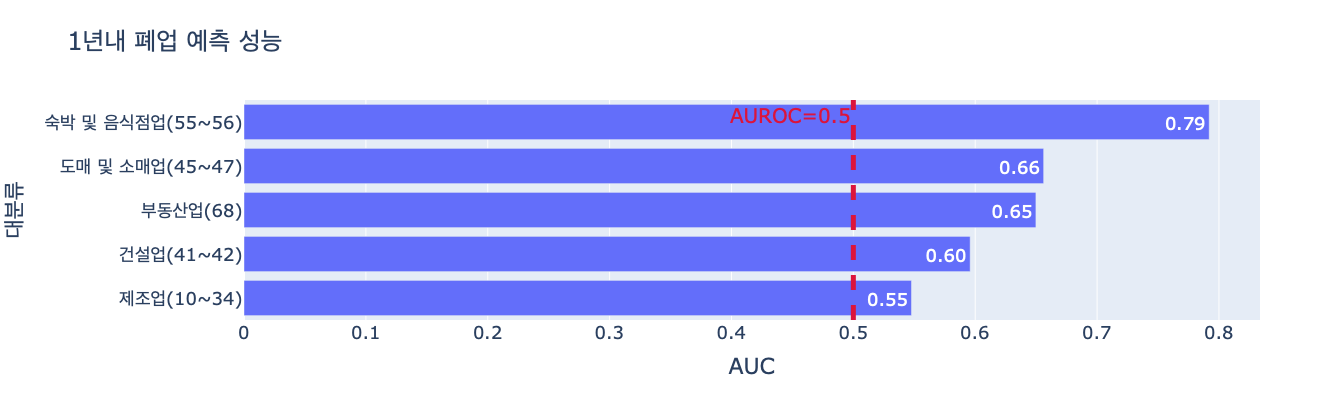

In [15]:
import plotly.express as px

tmp = (
    data_toplot
    .copy()
    .loc[lambda x: x['target']=='Closed_In_1Yr']
    .groupby(['대분류'])['AUC'].mean().to_frame().reset_index(drop=False).sort_values(by='AUC')
)
fig = px.bar(tmp, y='대분류', x='AUC', title='1년내 폐업 예측 성능', orientation='h', text_auto='.2f')
fig.add_vline(x=0.5, 
              line_dash='dash', 
              line_color='crimson', 
              line_width=5,
              annotation_text="AUROC=0.5", 
              annotation_position="top left",
              annotation_font_color='crimson',
              annotation_font_size=20
             )
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    font=dict(size=18)
)

figure_name = 'Baseline_result_closed_in_1yr.png'
fig.write_image(FIGURE_PATH / figure_name)
fig.show()

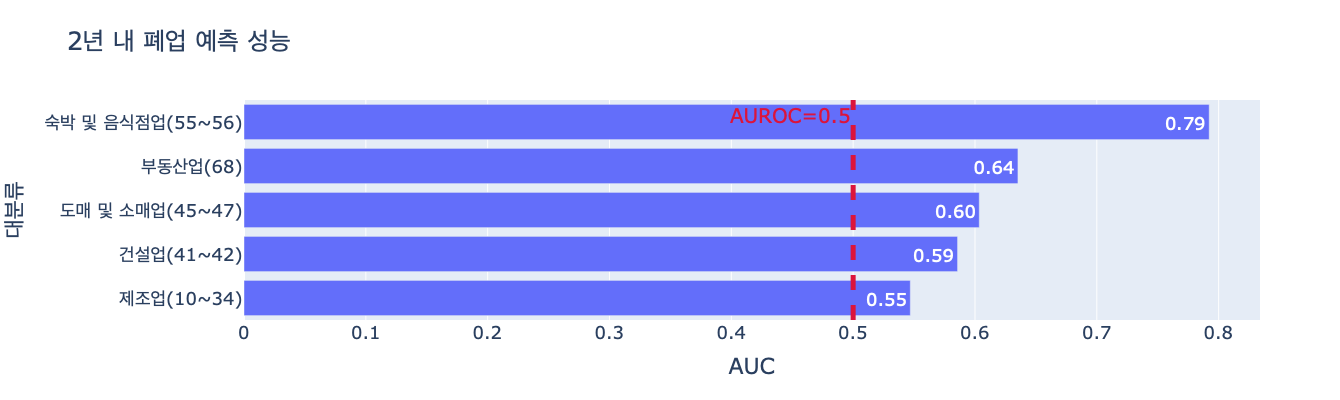

In [14]:
tmp = (
    data_toplot
    .copy()
    .loc[lambda x: x['target']=='Closed_In_2Yrs']
    .groupby(['대분류'])['AUC'].mean().to_frame().reset_index(drop=False).sort_values(by='AUC')
)
fig = px.bar(tmp, y='대분류', x='AUC', title='2년 내 폐업 예측 성능', orientation='h', text_auto='.2f')
fig.add_vline(x=0.5, 
              line_dash='dash', 
              line_color='crimson', 
              line_width=5,
              annotation_text="AUROC=0.5", 
              annotation_position="top left",
              annotation_font_color='crimson',
              annotation_font_size=20
             )
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    font=dict(size=18)
)

figure_name = 'Baseline_result_closed_in_2yrs.png'
fig.write_image(FIGURE_PATH / figure_name)
fig.show()

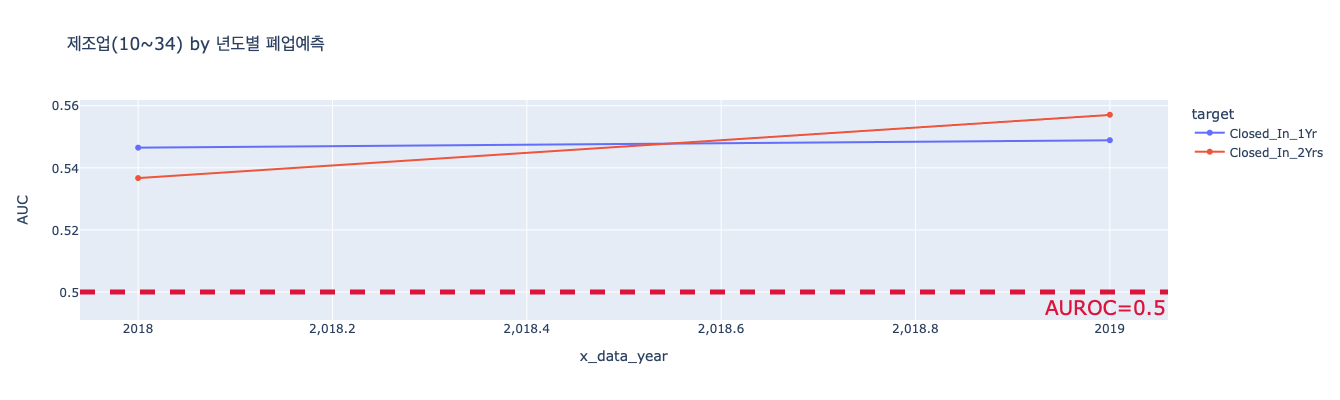

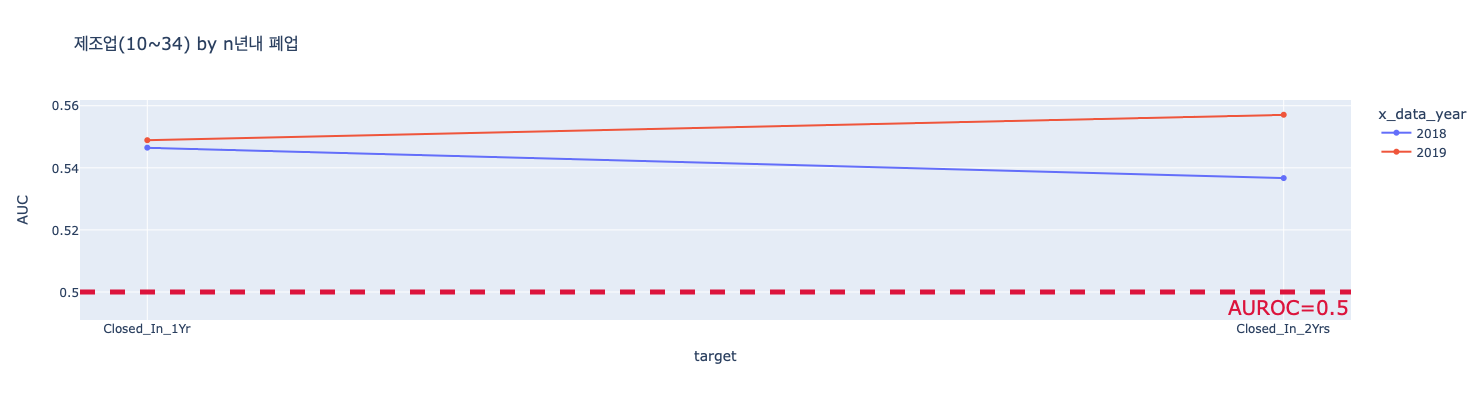

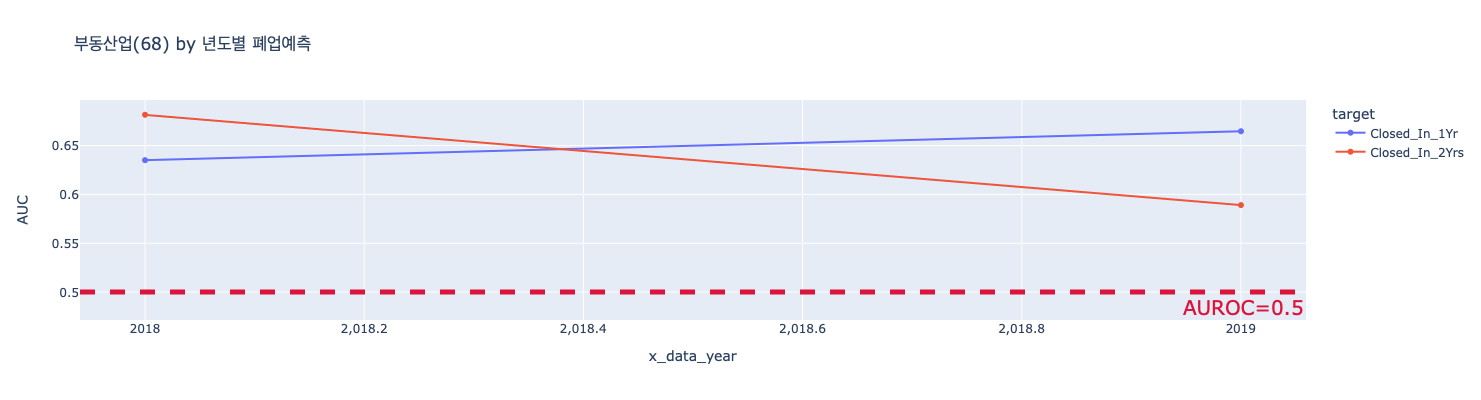

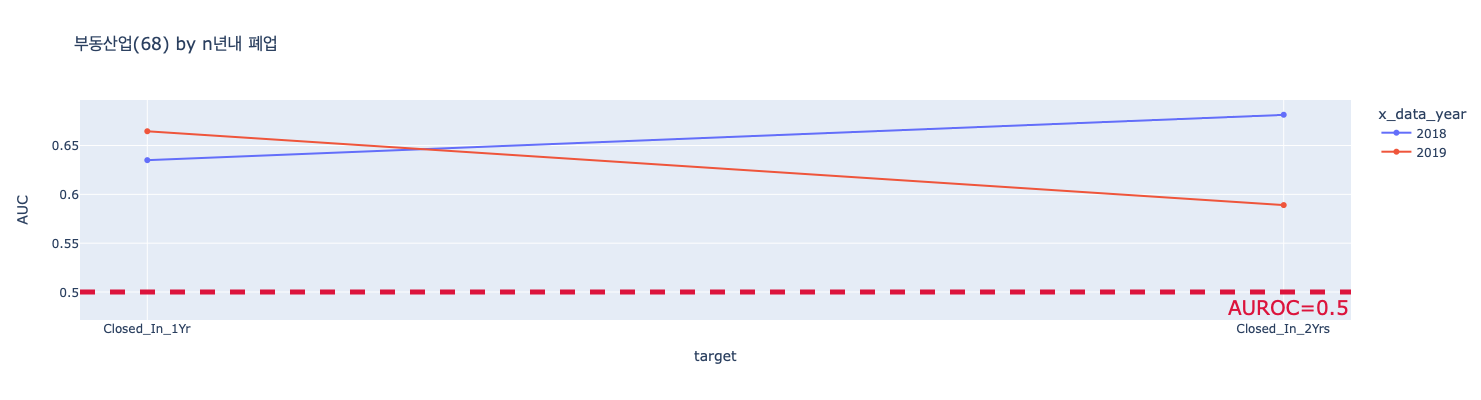

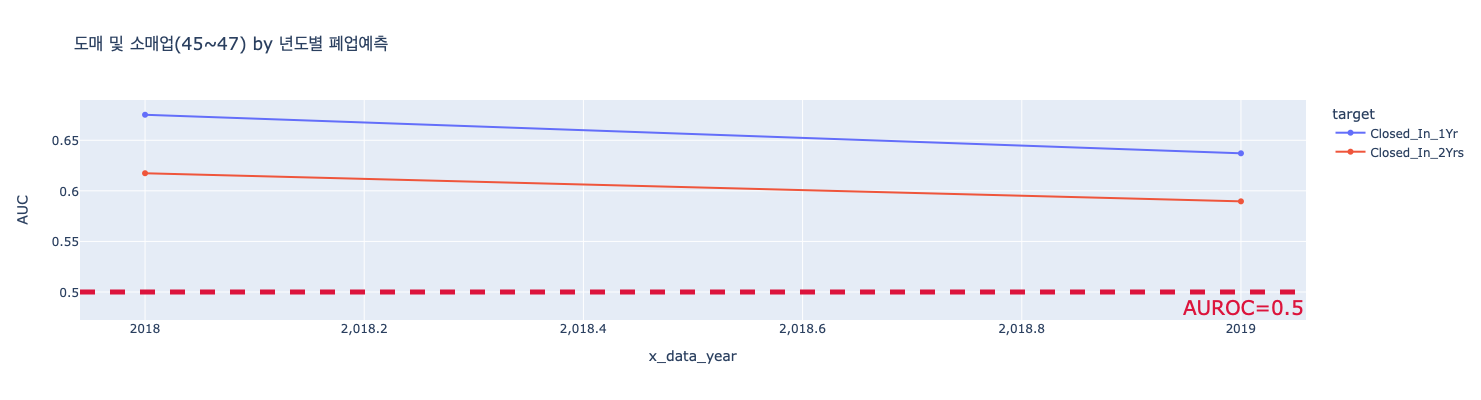

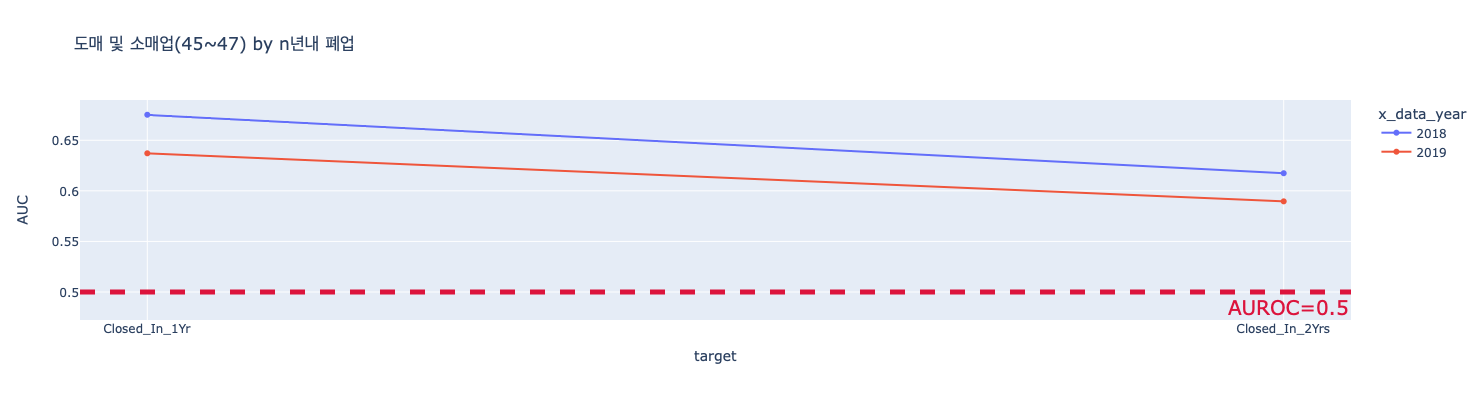

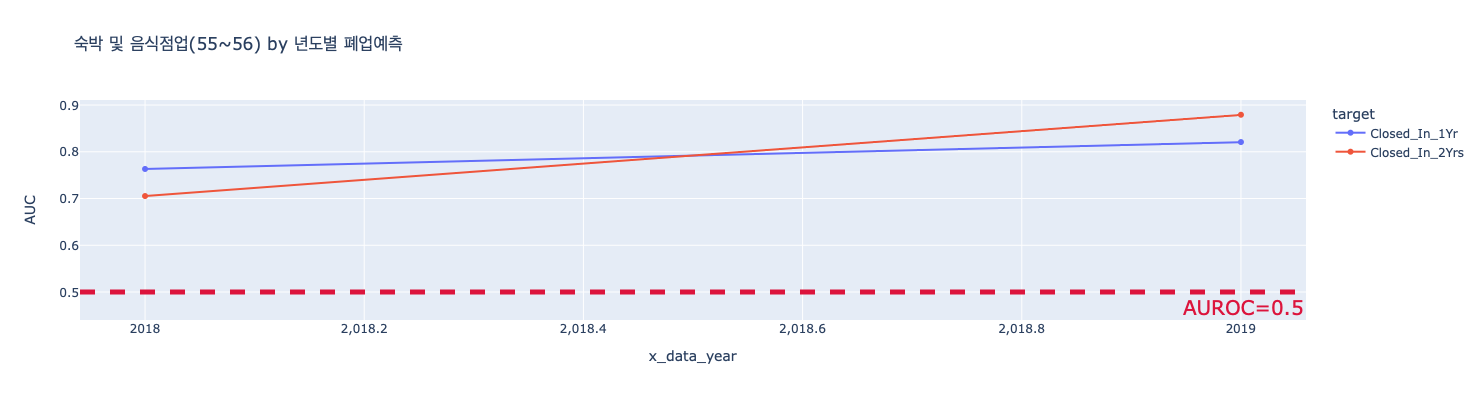

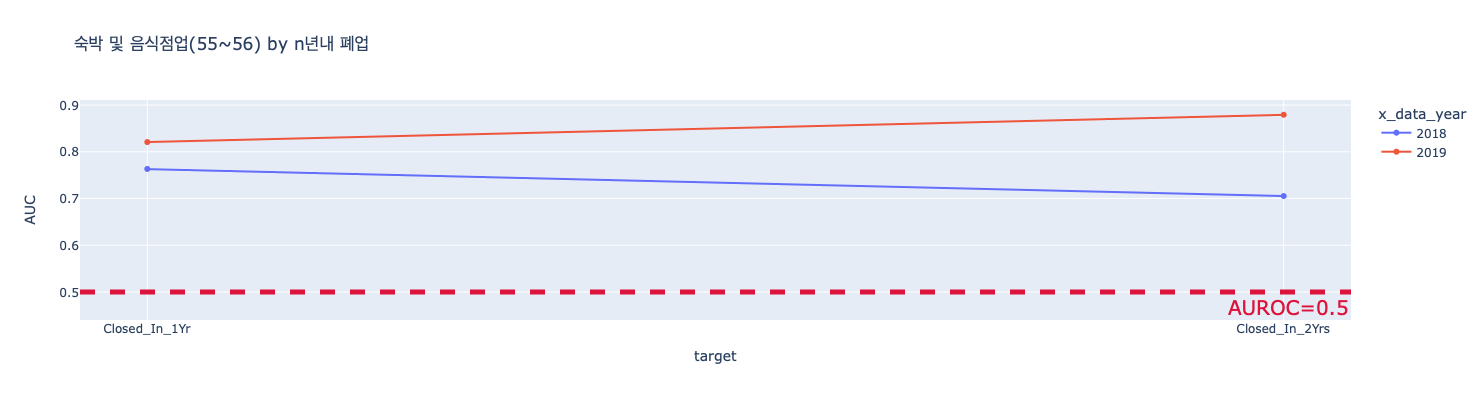

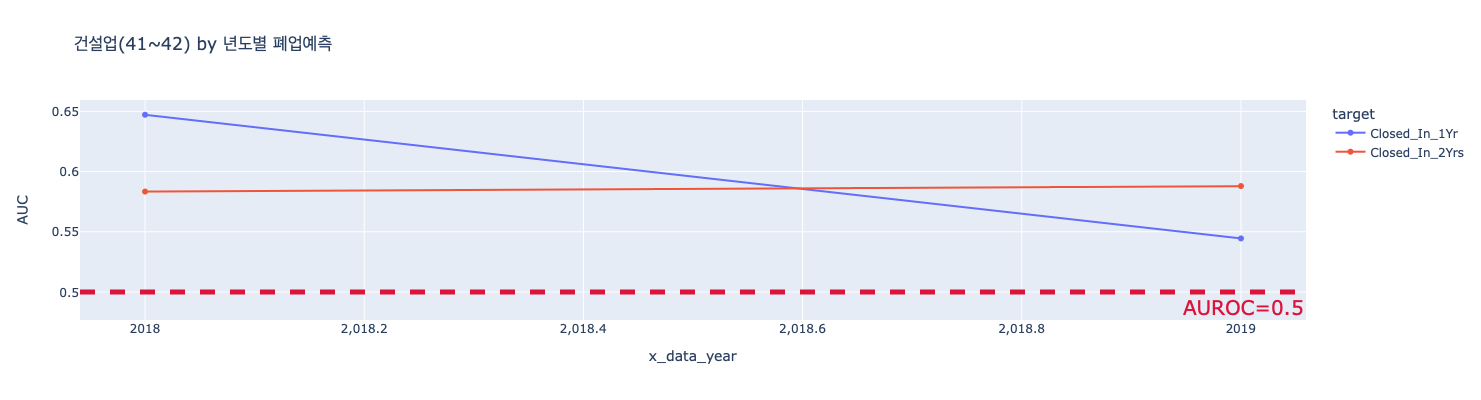

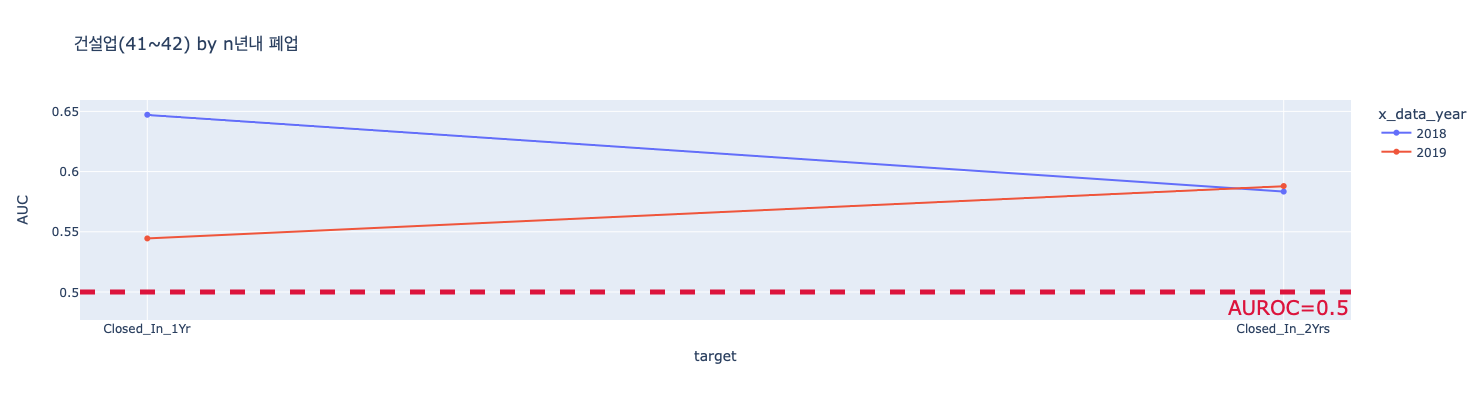

In [19]:
for sector in sectors : 
    fig = px.line(data_toplot.loc[lambda x : x['대분류']==sector],
                  x='x_data_year',
                  y='AUC',
                  color='target',
                  markers=True,
                  title=f'{sector} by 년도별 폐업예측'
                 )
    fig.update_layout(
        autosize=False,
        width=600,
        height=400,
    )
    fig.add_hline(y=0.5, 
              line_dash='dash', 
              line_color='crimson', 
              line_width=5,
              annotation_text="AUROC=0.5", 
              annotation_position="bottom right",
              annotation_font_color='crimson',
              annotation_font_size=20
             )
    figure_name = f'Baseline_result_{sector}_년도별.png'
    fig.write_image(FIGURE_PATH / figure_name)
    fig.show()

    fig = px.line(data_toplot.loc[lambda x : x['대분류']==sector],
                  x='target',
                  y='AUC',
                  color='x_data_year',
                  markers=True,
                  title=f'{sector} by n년내 폐업'
                 )
    fig.update_layout(
        autosize=False,
        width=600,
        height=400,
    )
    fig.add_hline(y=0.5, 
              line_dash='dash', 
              line_color='crimson', 
              line_width=5,
              annotation_text="AUROC=0.5", 
              annotation_position="bottom right",
              annotation_font_color='crimson',
              annotation_font_size=20
             )
    figure_name = f'Baseline_result_{sector}_n년내폐업.png'
    fig.write_image(FIGURE_PATH / figure_name)
    fig.show()

In [20]:
data_toplot = (
    exp_result
    .rename(columns={'x_data_yaer':'x_data_year'})
    .loc[lambda x : x['x_data_year']!=2022]
    .groupby(['대분류', 'x_data_year', 'target'])
    ['AUC'].max()
    .to_frame()
    .reset_index(drop=False)
    .groupby(['x_data_year', 'target'])
    ['AUC'].mean()
    .to_frame()
    .reset_index()
    .loc[lambda x : x['x_data_year']!=2020]
)
data_toplot

,x_data_year,target,AUC
0,2018,Closed_In_1Yr,0.65342
1,2018,Closed_In_2Yrs,0.62486
2,2019,Closed_In_1Yr,0.64318
3,2019,Closed_In_2Yrs,0.64058


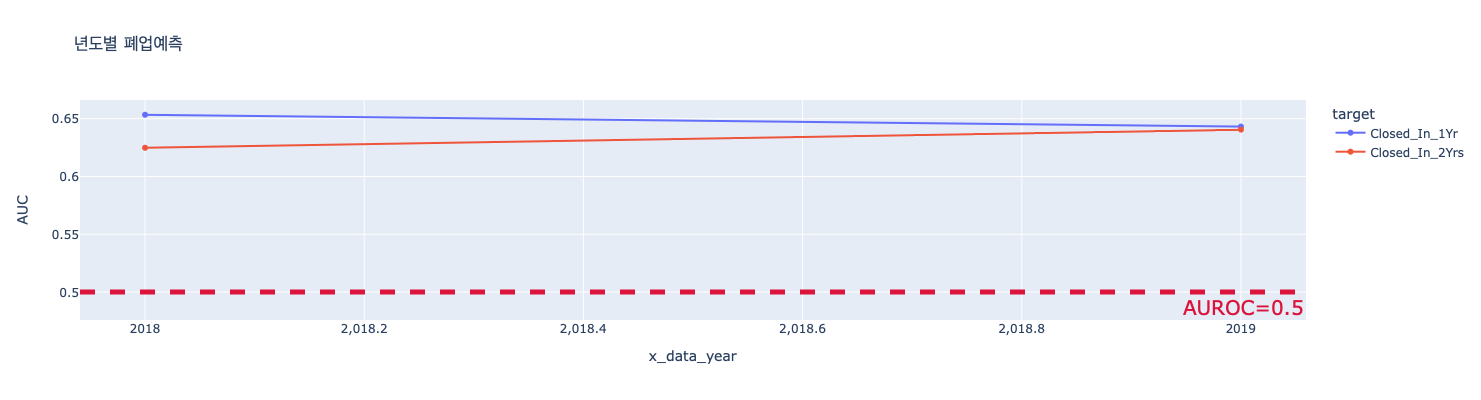

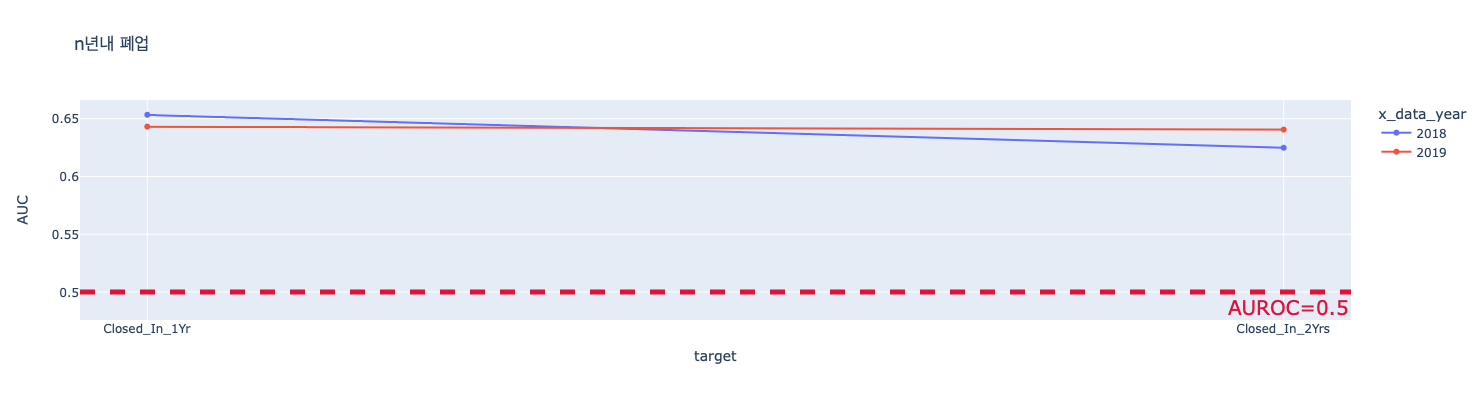

In [22]:
fig = px.line(data_toplot,
              x='x_data_year',
              y='AUC',
              color='target',
              markers=True,
              title=f'년도별 폐업예측'
             )
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
)
fig.add_hline(y=0.5, 
              line_dash='dash', 
              line_color='crimson', 
              line_width=5,
              annotation_text="AUROC=0.5", 
              annotation_position="bottom right",
              annotation_font_color='crimson',
              annotation_font_size=20
             )
figure_name = 'Baseline_result_년도별.png'
fig.write_image(FIGURE_PATH / figure_name)
fig.show()

fig = px.line(data_toplot,
              x='target',
              y='AUC',
              color='x_data_year',
              markers=True,
              title=f'n년내 폐업'
             )
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
)
fig.add_hline(y=0.5, 
              line_dash='dash', 
              line_color='crimson', 
              line_width=5,
              annotation_text="AUROC=0.5", 
              annotation_position="bottom right",
              annotation_font_color='crimson',
              annotation_font_size=20
             )
figure_name = 'Baseline_result_n년내폐업.png'
fig.write_image(FIGURE_PATH / figure_name)
fig.show()